In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv("./merged_features.csv")
dataset_wo_activity = dataset.drop(columns=['activity'])

In [20]:
plt.figure(figsize=(100,100))
corr_matrix = dataset_wo_activity.corr()
corr_map = sns.heatmap(corr_matrix, annot=True, cmap='vlag')
fig = corr_map.get_figure()
fig.savefig("corr_heatmap.png") 

In [21]:
import numpy as np
def findCorrelation(corr, cutoff=0.9, exact=None):

    """
    This function is the Python implementation of the R function 
    `findCorrelation()`.
    
    Relies on numpy and pandas, so must have them pre-installed.
    
    It searches through a correlation matrix and returns a list of column names 
    to remove to reduce pairwise correlations.
    
    For the documentation of the R function, see 
    https://www.rdocumentation.org/packages/caret/topics/findCorrelation
    and for the source code of `findCorrelation()`, see
    https://github.com/topepo/caret/blob/master/pkg/caret/R/findCorrelation.R
    
    -----------------------------------------------------------------------------

    Parameters:
    -----------
    corr: pandas dataframe.
        A correlation matrix as a pandas dataframe.
    cutoff: float, default: 0.9.
        A numeric value for the pairwise absolute correlation cutoff
    exact: bool, default: None
        A boolean value that determines whether the average correlations be 
        recomputed at each step
    -----------------------------------------------------------------------------
    Returns:
    --------
    list of column names
    -----------------------------------------------------------------------------
    Example:
    --------
    R1 = pd.DataFrame({
        'x1': [1.0, 0.86, 0.56, 0.32, 0.85],
        'x2': [0.86, 1.0, 0.01, 0.74, 0.32],
        'x3': [0.56, 0.01, 1.0, 0.65, 0.91],
        'x4': [0.32, 0.74, 0.65, 1.0, 0.36],
        'x5': [0.85, 0.32, 0.91, 0.36, 1.0]
    }, index=['x1', 'x2', 'x3', 'x4', 'x5'])

    findCorrelation(R1, cutoff=0.6, exact=False)  # ['x4', 'x5', 'x1', 'x3']
    findCorrelation(R1, cutoff=0.6, exact=True)   # ['x1', 'x5', 'x4'] 
    """
    
    def _findCorrelation_fast(corr, avg, cutoff):

        combsAboveCutoff = corr.where(lambda x: (np.tril(x)==0) & (x > cutoff)).stack().index

        rowsToCheck = combsAboveCutoff.get_level_values(0)
        colsToCheck = combsAboveCutoff.get_level_values(1)

        msk = avg[colsToCheck] > avg[rowsToCheck].values
        deletecol = pd.unique(np.r_[colsToCheck[msk], rowsToCheck[~msk]]).tolist()

        return deletecol


    def _findCorrelation_exact(corr, avg, cutoff):

        x = corr.loc[(*[avg.sort_values(ascending=False).index]*2,)]

        if (x.dtypes.values[:, None] == ['int64', 'int32', 'int16', 'int8']).any():
            x = x.astype(float)

        x.values[(*[np.arange(len(x))]*2,)] = np.nan

        deletecol = []
        for ix, i in enumerate(x.columns[:-1]):
            for j in x.columns[ix+1:]:
                if x.loc[i, j] > cutoff:
                    if x[i].mean() > x[j].mean():
                        deletecol.append(i)
                        x.loc[i] = x[i] = np.nan
                    else:
                        deletecol.append(j)
                        x.loc[j] = x[j] = np.nan
        return deletecol

    
    if not np.allclose(corr, corr.T) or any(corr.columns!=corr.index):
        raise ValueError("correlation matrix is not symmetric.")
        
    acorr = corr.abs()
    avg = acorr.mean()
        
    if exact or exact is None and corr.shape[1]<100:
        return _findCorrelation_exact(acorr, avg, cutoff)
    else:
        return _findCorrelation_fast(acorr, avg, cutoff)

In [22]:
hc = findCorrelation(corr_matrix, cutoff=0.4)
trimmed_df = dataset_wo_activity.drop(columns=hc)

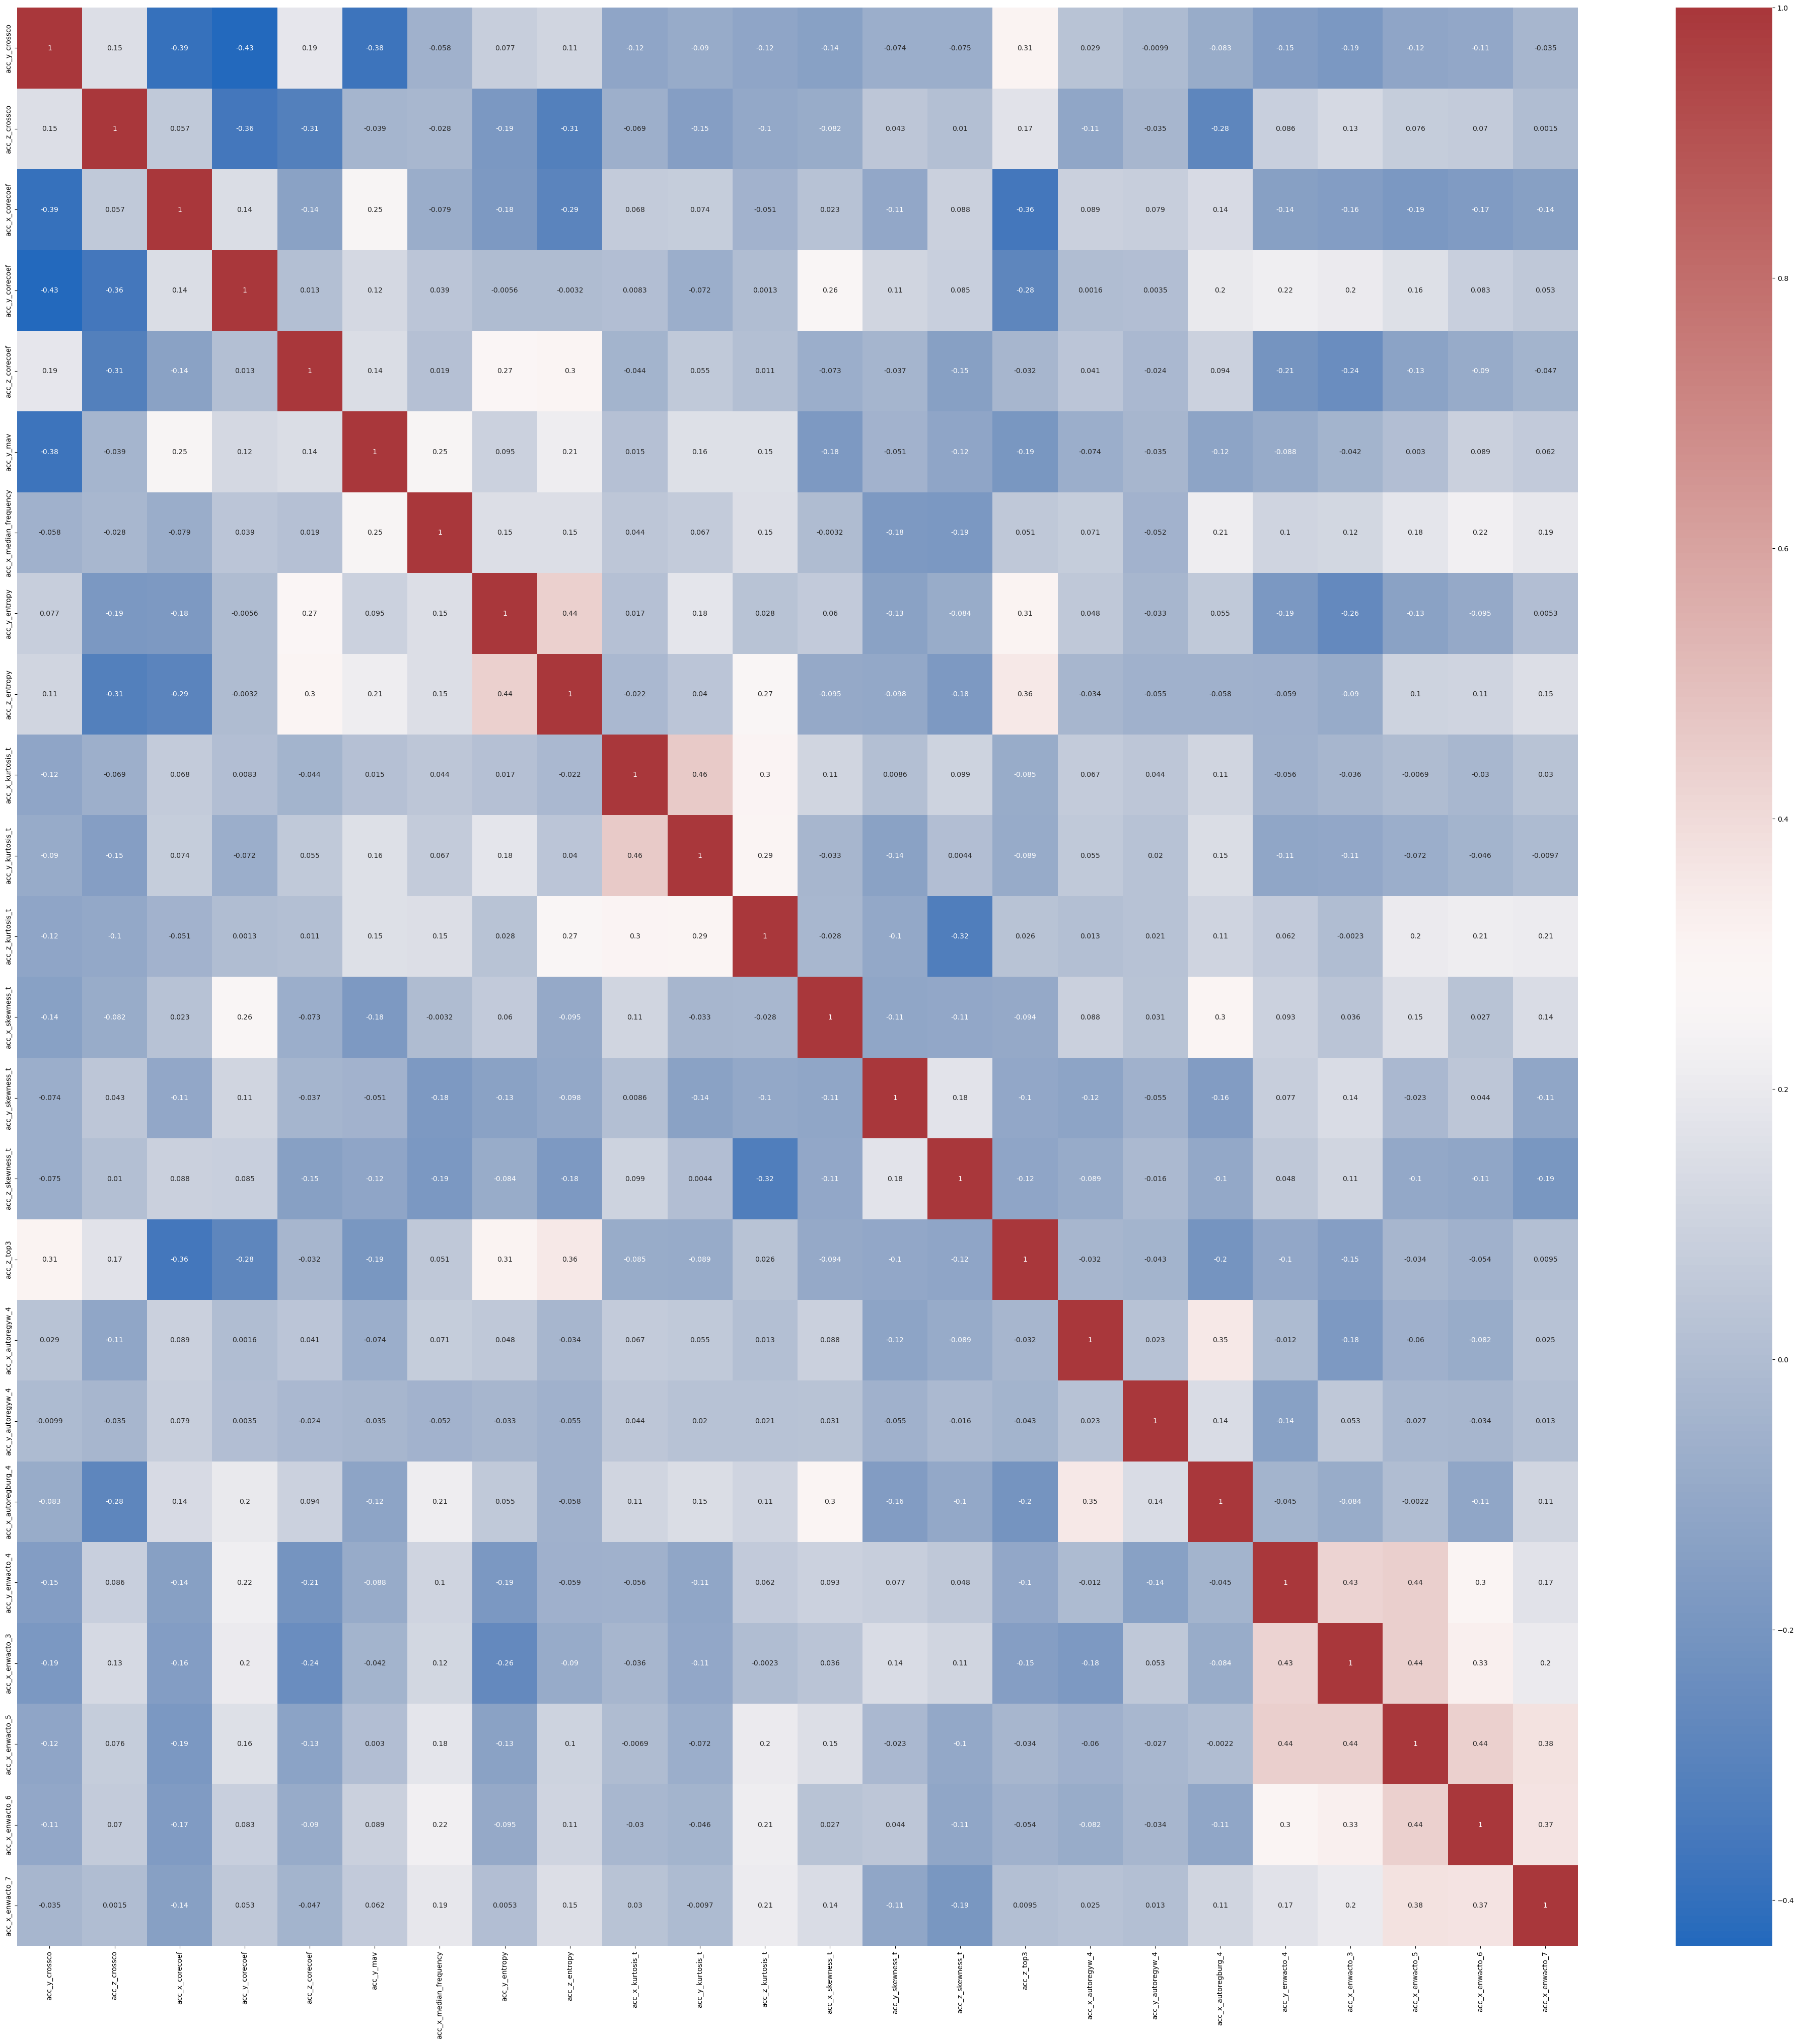

In [18]:
plt.figure(figsize=(50,50))
corr_matrix = trimmed_df.corr()
corr_map = sns.heatmap(corr_matrix, annot=True, cmap='vlag')
fig = corr_map.get_figure()
fig.savefig("corr_trimmed.png") 

In [23]:
from sklearn.model_selection import train_test_split

X = trimmed_df
y = dataset['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [24]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

svm_clf = SVC(kernel='rbf', probability=True, random_state=5)
svm_clf.fit(X_train.values, y_train)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=5)
rnd_clf.fit(X_train.values, y_train)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train.values, y_train)

KNeighborsClassifier()

In [26]:
print(svm_clf.score(X_test.values, y_test))
print(rnd_clf.score(X_test.values, y_test))
print(knn_clf.score(X_test.values, y_test))

0.8091603053435115
0.9465648854961832
0.916030534351145


In [29]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier([
    ("svm_clf", svm_clf),
    ("rnd_clf", rnd_clf),
    ("knn_clf", knn_clf)
], voting="soft")

voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('svm_clf', SVC(probability=True, random_state=5)),
                             ('rnd_clf',
                              RandomForestClassifier(random_state=5)),
                             ('knn_clf', KNeighborsClassifier())],
                 voting='soft')

In [30]:
voting_clf.score(X_test, y_test)

0.9465648854961832